FISHDBC (Flexible, Incremental, Scalable and Hierarchical density-based clustering algorithm)

It is density-based and approximates HDBSCAN, which is an evolution of DBSCAN

- Flexible: allows users to define distance function 
- Incremental & Scalable: avoids O(n^2) of other hierarchical clustering methods. Lightweight computation to upsdate the clusters when few data points are added
- Hierarchical: produces a 'flat' clustering that can be expanded to a tree structure, so users can split/ merge clusters in sub-super clusters during data exploration

In [1]:
import collections
import itertools

import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt

from flexible_clustering import FISHDBC

import pandas as pd

In [2]:
import tensorflow as tf

# Iris FISHDBC

In [4]:
import sklearn.datasets
from sklearn.model_selection import train_test_split

In [5]:
iris = datasets.load_iris()

X = iris['data']
y = iris['target']

df = pd.DataFrame(X)
df['Class'] = y

df.columns=['F1', 'F2', 'F3', 'F4', 'Class']

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score

In [7]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)

y_encoded = pd.get_dummies(y_train)
y_encoded = np.array(y_encoded)

### Functions for visualising/ creating projections

In [8]:
from scipy.stats import norm
import statistics

In [9]:
# Gets the datapoints and centroid coordinates for a particular cluster
def get_data_centroid(X, y_pred, cluster_label):
    datapoints = X[y_pred==cluster_label]
    centroid_coord = np.mean(datapoints, axis=0) 
    return datapoints, centroid_coord

# Gets the mean and std of a particular cluster (for 1 dimension only)
def mean_std(cluster_data, dim):
    points = cluster_data[:,dim]
    return statistics.mean(points), statistics.stdev(points)

# Gets the data required for each dimension (for all clusters)
def get_dimension_dict(X, num_clusters, dim, y_pred):
    dim_dict = {}
    
    for i in range(num_clusters):
        dim_dict["cluster"+str(i)] = {}
        data, centroid = get_data_centroid(X, y_pred, i)
        data_mean, data_std = mean_std(data, dim)
        dim_dict["cluster"+str(i)]["data"] = data
        dim_dict["cluster"+str(i)]["centroid"] = centroid
        dim_dict["cluster"+str(i)]["mean"] = data_mean
        dim_dict["cluster"+str(i)]["std"] = data_std
        
    return dim_dict

# Plot the gaussian projections of each cluster on the specified dimension
def plot_projection(dim_dict, num_clusters, title, show_vertical=False):
    
    plt.subplot(1,1,1)
    plt.title(title)
    for i in range(num_clusters):
        mean = dim_dict["cluster"+str(i)]["mean"]
        std = dim_dict["cluster"+str(i)]["std"]
        # if all datapoints same value (no pdf)
        if show_vertical == True:
            if std == 0:
                plt.axvline(x=mean, ymin=0, ymax=1, color='black', label="Cluster #" + str(i))
                continue
        x = np.linspace(mean - 6*std, mean+6*std, 100)
        y = norm.pdf(x, mean, std)
        plt.plot(x, y/max(y), label="Cluster #"+str(i))
        
    plt.legend(bbox_to_anchor=(1.35, 0.7))

In [10]:
def distance(x, y):
    return numpy.linalg.norm(x - y)

### Functions for creating memberships

In [11]:
def dimension_projection(data, y_pred, title, dim):
    num_outliers = (np.sum(np.array(y_pred) == -1, axis=0))
    num_clusters = (len(set(y_pred)) - (1 if -1 in y_pred else 0))
    print('Number of noise points: ', num_outliers)
    print("Number of clusters: ", num_clusters)

    unique = pd.DataFrame(np.unique(y_pred, return_counts = True))
    print("Unqiue Clusters: ")
    display(unique)

    print("Centroids: ")
    for i in range(num_clusters):
        print("centroid", str(i), ": ", get_data_centroid(data, y_pred, i)[1])

    dim_dict = get_dimension_dict(data, num_clusters, dim, y_pred)
    plot_projection(dim_dict, num_clusters, title)

    return num_clusters, dim_dict

In [12]:
def output_fuzzy_memberships(dim_dict, num_clusters, dim_data_pt):
    fuzzy_memberships = []
    for i in range(num_clusters):
        mean = dim_dict["cluster"+str(i)]["mean"]
        std = dim_dict["cluster"+str(i)]["std"]
        if std == 0:
            if dim_data_pt == mean:
                fuzzy_memberships.append(1)
            else:
                fuzzy_memberships.append(0)
            continue
        pdf = norm(mean, std).pdf(dim_data_pt)
        max_y = norm(mean, std).pdf(mean)
        fuzzy_memberships.append(pdf/max_y)
        
    return fuzzy_memberships

# Localised (Dim 1)

In [13]:
F1 = df[['F1']].values
true_labels = iris['target']

In [14]:
fishdbc = FISHDBC(distance)

# plt.figure(figsize=(9, 9))
# plt.gca().set_aspect('equal')

n_iters = 3
for points in np.split(F1, n_iters):
    fishdbc.update(points)
    print("num of added points: ", len(points))
    nknown = len(fishdbc.data)
    print("total data now: ", nknown)
    labels, probs, stabilities, ctree, slt, mst = fishdbc.cluster()
    clusters = collections.defaultdict(set)
    for parent, child, lambda_val, child_size in ctree[::-1]:
        if child_size == 1:
            clusters[parent].add(child)
        else:
            assert len(clusters[child]) == child_size
            clusters[parent].update(clusters[child])
    clusters = sorted(clusters.items())
    xknown, yknown, labels_known = F1[:nknown], F1[:nknown], true_labels[:nknown]
    color = ['rgbcmyk'[l % 7] for l in labels_known]
#     plt.scatter(xknown, yknown, c=color, linewidth=0)
#     plt.show(block=False)

IN FISHDBC initiated!
In FISHDBC update function!
updating mst...
IN updating mst!
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8319ccb2d0>
num of added points:  50
total data now:  50
IN cluster function!
IN updating mst!
In FISHDBC update function!
updating mst...
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8330967690>
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8320de46e0>
num of added points:  50
total data now:  100
IN cluster function!
IN updating mst!
In FISHDBC update function!
updating mst...
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8320de2e10>
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8319cef2d0>
num of added points:  50
total data now:  150
IN cluster funct

In [15]:
# clustering result
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([26,  6, 14, 13,  5, 11,  7,  8,  9,  6,  6,  6,  7,  7,  9, 10]))

In [16]:
y_pred = labels
num_outliers = (np.sum(np.array(y_pred) == -1, axis=0))
num_clusters = (len(set(y_pred)) - (1 if -1 in y_pred else 0))
print('Number of noise points: ', num_outliers)
print("Number of clusters: ", num_clusters)

Number of noise points:  26
Number of clusters:  15


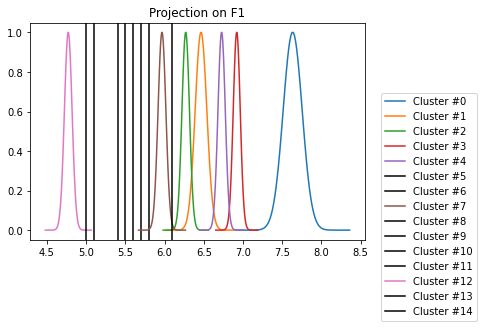

In [17]:
dim = 0
dim_dict = get_dimension_dict(F1, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F1", True)

In [18]:
output_fuzzy_memberships(dim_dict, num_clusters, 5.1)

[9.585870003332139e-96,
 1.476436133918306e-73,
 2.289535116589241e-129,
 0.0,
 2.844374938884006e-264,
 0,
 0,
 5.745367715223622e-66,
 0,
 0,
 0,
 0,
 1.4253570710566696e-10,
 1,
 0]

In [19]:
train_F1_data = list(X_train[:, 0])
test_F1_data = list(X_test[:, 0])

train_F1_fuzzified = []
for i in train_F1_data:
    fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
    train_F1_fuzzified.append(fuzzified)

test_F1_fuzzified = []
for i in test_F1_data:
    fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
    test_F1_fuzzified.append(fuzzified)

# Localied (Dim 2)

In [20]:
F2 = df[['F2']].values

In [21]:
fishdbc = FISHDBC(distance)

# plt.figure(figsize=(9, 9))
# plt.gca().set_aspect('equal')

n_iters = 3
for points in np.split(F2, n_iters):
    fishdbc.update(points)
    print("num of added points: ", len(points))
    nknown = len(fishdbc.data)
    print("total data now: ", nknown)
    labels, probs, stabilities, ctree, slt, mst = fishdbc.cluster()
    clusters = collections.defaultdict(set)
    for parent, child, lambda_val, child_size in ctree[::-1]:
        if child_size == 1:
            clusters[parent].add(child)
        else:
            assert len(clusters[child]) == child_size
            clusters[parent].update(clusters[child])
    clusters = sorted(clusters.items())
    xknown, yknown, labels_known = F2[:nknown], F2[:nknown], true_labels[:nknown]
    color = ['rgbcmyk'[l % 7] for l in labels_known]
#     plt.scatter(xknown, yknown, c=color, linewidth=0)
#     plt.show(block=False)

IN FISHDBC initiated!
In FISHDBC update function!
updating mst...
IN updating mst!
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f83309d9b90>
num of added points:  50
total data now:  50
IN cluster function!
IN updating mst!
In FISHDBC update function!
updating mst...
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8314747a00>
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8330a27a00>
num of added points:  50
total data now:  100
IN cluster function!
IN updating mst!
In FISHDBC update function!
updating mst...
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8330a270a0>
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8330a17b90>
num of added points:  50
total data now:  150
IN cluster funct

In [22]:
# clustering result
print(np.unique(labels, return_counts=True))

y_pred = labels
num_outliers = (np.sum(np.array(y_pred) == -1, axis=0))
num_clusters = (len(set(y_pred)) - (1 if -1 in y_pred else 0))
print('Number of noise points: ', num_outliers)
print("Number of clusters: ", num_clusters)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([24, 10,  8, 14,  9,  9,  7, 12, 13,  6,  6, 26,  6]))
Number of noise points:  24
Number of clusters:  12


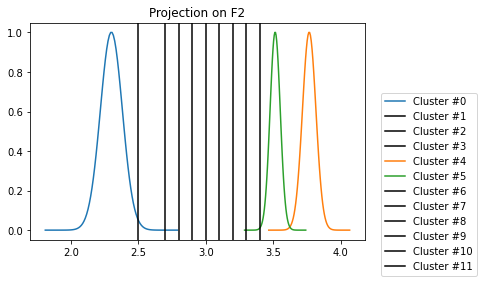

In [23]:
dim = 0
dim_dict = get_dimension_dict(F2, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F2", True)

In [24]:
train_F2_data = list(X_train[:, 1])
test_F2_data = list(X_test[:, 1])

train_F2_fuzzified = []
for i in train_F2_data:
    fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
    train_F2_fuzzified.append(fuzzified)

test_F2_fuzzified = []
for i in test_F2_data:
    fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
    test_F2_fuzzified.append(fuzzified)

# Localised (Dim 3)

In [25]:
F3 = df[['F3']].values

In [26]:
fishdbc = FISHDBC(distance)

# plt.figure(figsize=(9, 9))
# plt.gca().set_aspect('equal')

n_iters = 3
for points in np.split(F3, n_iters):
    fishdbc.update(points)
    print("num of added points: ", len(points))
    nknown = len(fishdbc.data)
    print("total data now: ", nknown)
    labels, probs, stabilities, ctree, slt, mst = fishdbc.cluster()
    clusters = collections.defaultdict(set)
    for parent, child, lambda_val, child_size in ctree[::-1]:
        if child_size == 1:
            clusters[parent].add(child)
        else:
            assert len(clusters[child]) == child_size
            clusters[parent].update(clusters[child])
    clusters = sorted(clusters.items())
    xknown, yknown, labels_known = F3[:nknown], F3[:nknown], true_labels[:nknown]
    color = ['rgbcmyk'[l % 7] for l in labels_known]
#     plt.scatter(xknown, yknown, c=color, linewidth=0)
#     plt.show(block=False)

IN FISHDBC initiated!
In FISHDBC update function!
updating mst...
IN updating mst!
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8330a8f690>
num of added points:  50
total data now:  50
IN cluster function!
IN updating mst!
In FISHDBC update function!
updating mst...
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8319d9bc80>
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8330abfaa0>
num of added points:  50
total data now:  100
IN cluster function!
IN updating mst!
In FISHDBC update function!
updating mst...
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f833098a0a0>
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8319dd2cd0>
num of added points:  50
total data now:  150
IN cluster funct

In [27]:
# clustering result
print(np.unique(labels, return_counts=True))

y_pred = labels
num_outliers = (np.sum(np.array(y_pred) == -1, axis=0))
num_clusters = (len(set(y_pred)) - (1 if -1 in y_pred else 0))
print('Number of noise points: ', num_outliers)
print("Number of clusters: ", num_clusters)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([29, 11, 13, 13,  7,  9, 10,  6, 11,  9,  8,  9, 15]))
Number of noise points:  29
Number of clusters:  12


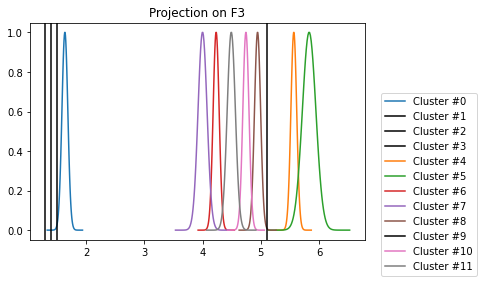

In [28]:
dim = 0
dim_dict = get_dimension_dict(F3, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F3", True)

In [29]:
train_F3_data = list(X_train[:, 2])
test_F3_data = list(X_test[:, 2])

train_F3_fuzzified = []
for i in train_F3_data:
    fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
    train_F3_fuzzified.append(fuzzified)

test_F3_fuzzified = []
for i in test_F3_data:
    fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
    test_F3_fuzzified.append(fuzzified)

# Localised (Dim 4)

In [30]:
F4 = df[['F4']].values

In [31]:
fishdbc = FISHDBC(distance)

# plt.figure(figsize=(9, 9))
# plt.gca().set_aspect('equal')

n_iters = 3
for points in np.split(F4, n_iters):
    fishdbc.update(points)
    print("num of added points: ", len(points))
    nknown = len(fishdbc.data)
    print("total data now: ", nknown)
    labels, probs, stabilities, ctree, slt, mst = fishdbc.cluster()
    clusters = collections.defaultdict(set)
    for parent, child, lambda_val, child_size in ctree[::-1]:
        if child_size == 1:
            clusters[parent].add(child)
        else:
            assert len(clusters[child]) == child_size
            clusters[parent].update(clusters[child])
    clusters = sorted(clusters.items())
    xknown, yknown, labels_known = F4[:nknown], F4[:nknown], true_labels[:nknown]
    color = ['rgbcmyk'[l % 7] for l in labels_known]
#     plt.scatter(xknown, yknown, c=color, linewidth=0)
#     plt.show(block=False)

IN FISHDBC initiated!
In FISHDBC update function!
updating mst...
IN updating mst!
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8319da09b0>
num of added points:  50
total data now:  50
IN cluster function!
IN updating mst!
In FISHDBC update function!
updating mst...
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8319e1bb90>
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8319cdecd0>
num of added points:  50
total data now:  100
IN cluster function!
IN updating mst!
In FISHDBC update function!
updating mst...
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f8319cdecd0>
IN updating mst!
In unionfind.pyx init!
Union Find:  <flexible_clustering.unionfind.UnionFind object at 0x7f83147b6d70>
num of added points:  50
total data now:  150
IN cluster funct

In [32]:
# clustering result
print(np.unique(labels, return_counts=True))

y_pred = labels
num_outliers = (np.sum(np.array(y_pred) == -1, axis=0))
num_clusters = (len(set(y_pred)) - (1 if -1 in y_pred else 0))
print('Number of noise points: ', num_outliers)
print("Number of clusters: ", num_clusters)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([ 7,  6,  8,  6, 11,  6, 17,  7,  8,  6, 29,  7, 12,  7, 13]))
Number of noise points:  7
Number of clusters:  14


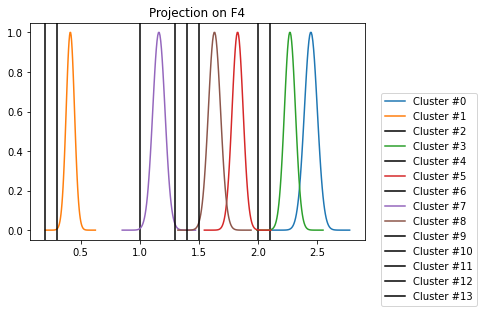

In [33]:
dim = 0
dim_dict = get_dimension_dict(F4, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F4", True)

In [34]:
train_F4_data = list(X_train[:, 3])
test_F4_data = list(X_test[:, 3])

train_F4_fuzzified = []
for i in train_F4_data:
    fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
    train_F4_fuzzified.append(fuzzified)

test_F4_fuzzified = []
for i in test_F4_data:
    fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
    test_F4_fuzzified.append(fuzzified)

# Fuzzification of inputs

In [35]:
train_all_fuzzified = []
for i in range(len(train_F1_fuzzified)):
    one_data = []
    one_data.extend(train_F1_fuzzified[i])
    one_data.extend(train_F2_fuzzified[i])
    one_data.extend(train_F3_fuzzified[i])
    one_data.extend(train_F4_fuzzified[i])
    train_all_fuzzified.append(one_data)

test_all_fuzzified = []
for i in range(len(test_F1_fuzzified)):
    one_data = []
    one_data.extend(test_F1_fuzzified[i])
    one_data.extend(test_F2_fuzzified[i])
    one_data.extend(test_F3_fuzzified[i])
    one_data.extend(test_F4_fuzzified[i])
    test_all_fuzzified.append(one_data)

In [36]:
X_train_fuzzified = np.array(train_all_fuzzified)
X_test_fuzzified= np.array(test_all_fuzzified)

In [37]:
model = Sequential()

model.add(Dense(36, activation='tanh')) # input size is the total num_clusters from each dimension
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 10)

# fit network
history = model.fit(X_train_fuzzified, y_encoded, epochs=100, validation_split = 0.1, verbose=2)

Train on 108 samples, validate on 12 samples
Epoch 1/100
108/108 - 1s - loss: 1.1023 - accuracy: 0.2315 - val_loss: 1.1036 - val_accuracy: 0.2500
Epoch 2/100
108/108 - 0s - loss: 1.0764 - accuracy: 0.2870 - val_loss: 1.0922 - val_accuracy: 0.2500
Epoch 3/100
108/108 - 0s - loss: 1.0543 - accuracy: 0.3981 - val_loss: 1.0807 - val_accuracy: 0.3333
Epoch 4/100
108/108 - 0s - loss: 1.0333 - accuracy: 0.5278 - val_loss: 1.0687 - val_accuracy: 0.5000
Epoch 5/100
108/108 - 0s - loss: 1.0122 - accuracy: 0.5741 - val_loss: 1.0563 - val_accuracy: 0.5833
Epoch 6/100
108/108 - 0s - loss: 0.9919 - accuracy: 0.6481 - val_loss: 1.0444 - val_accuracy: 0.6667
Epoch 7/100
108/108 - 0s - loss: 0.9704 - accuracy: 0.6759 - val_loss: 1.0333 - val_accuracy: 0.7500
Epoch 8/100
108/108 - 0s - loss: 0.9478 - accuracy: 0.7222 - val_loss: 1.0211 - val_accuracy: 0.7500
Epoch 9/100
108/108 - 0s - loss: 0.9240 - accuracy: 0.7315 - val_loss: 1.0080 - val_accuracy: 0.7500
Epoch 10/100
108/108 - 0s - loss: 0.8984 - acc

Epoch 81/100
108/108 - 0s - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.5353 - val_accuracy: 0.9167
Epoch 82/100
108/108 - 0s - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.5438 - val_accuracy: 0.9167
Epoch 83/100
108/108 - 0s - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.5528 - val_accuracy: 0.9167
Epoch 84/100
108/108 - 0s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.5600 - val_accuracy: 0.9167
Epoch 85/100
108/108 - 0s - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.5660 - val_accuracy: 0.9167
Epoch 86/100
108/108 - 0s - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.5725 - val_accuracy: 0.9167
Epoch 87/100
108/108 - 0s - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.5783 - val_accuracy: 0.9167
Epoch 88/100
108/108 - 0s - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.5855 - val_accuracy: 0.9167
Epoch 89/100
108/108 - 0s - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.5945 - val_accuracy: 0.9167
Epoch 90/100
108/108 - 0s - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.6021 - v

In [38]:
y_pred_probs = model.predict(X_test_fuzzified)
y_pred = np.argmax(y_pred_probs, axis = 1)

In [39]:
accuracy_score(y_test, y_pred)

1.0

In [40]:
pd.DataFrame({"Actual" : y_test, 
              "Predicted" : y_pred})

,Actual,Predicted
73,1,1
18,0,0
118,2,2
78,1,1
76,1,1
31,0,0
64,1,1
141,2,2
68,1,1
82,1,1


In [41]:
# (1 + 0.966 + 0.866 + 0.933 + 0.9)/5